*Aprenentatge Computacional*

**Autor:**
- Sebastian Malbaceda Leyva (1681519)


# Cas Kaggle - Student Alcohol Consumption

En aquesta pràctica s'abordarà la creació d'un model d'aprenentatge computacional enfocat en classificació. Aquest model s'encarregarà de predir el nivell de consum d'alcohol dels estudiants als caps de setmana. Per poder aconseguir això, s'ha pogut recollir una sèrie de dades d'un institut. Aquestes dades són una sèrie de característiques de cada estudiant on es pot trobar informació tant relacionada amb l'ambient on es troba com amb el rendiment acadèmic que ha demostrat.

Per poder obtenir el millor model possible, seguirem una sèrie de passos on analitzarem les dades obtingudes, les processarem, triarem una sèrie de models candidats per entrenar i analitzarem els resultats obtinguts, decidint el millor classificador.

Importem les llibreries necessàries per a la manipulació, visualització i anàlisi de dades.

In [33]:
# LLIBRERIA PER MANIPULACIÓ DE DADES
import pandas as pd

# LLIBRERIA PER TREBALLAR AMB MATRIUS MULTIDIMENSIONALS
import numpy as np

# LLIBRERIA PER DETECTAR VALORS NULS
import missingno as msno

# LLIBRERIA PER VISUALITZAR DADES
import seaborn as sns
import matplotlib.pylab as plt

# LLIBRERIA PER EINES DE PREPROCESSING
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import StandardScaler

# LLIBRERIA PER IMPORTAR DIFERENTS MODELS
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# LLIBRERIA PER ANALITZAR DIFERENTS MODELS
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import accuracy_score,  precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# LLIBRERIA PER FER VALIDACIÓ DE DIFERENTS MODELS
from sklearn.model_selection import StratifiedKFold, cross_val_score, learning_curve, GridSearchCV, cross_val_predict

# LLIBRERIES PER TRANSFORMAR VARIABLES CATEGÒRIQUES A FORMATS NUMÈRICS
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# LLIBRERIA PER CREAR CÒPIES D'OBJECTES
import copy as cp

### 1. EDA (exploratory data analysis)

Previ a observar el dataset, hem de carregar tot el necessari per poder començar a treballar.

A la pàgina del cas Kaggle es pot trobar informació dels datasets que es carreguen. El que faré és utilitzar els dos datasets que pertanyen a dos grups d'alumnes d'un cert institut. Un d'ells és el de la classe de matemàtiques i l'altre és el dels alumnes de portuguès.

Per a l'anàlisi de dades, el que es farà serà utilitzar els dos datasets de manera concatenada, és a dir, juntarem tots dos datasets per poder tenir un model més estable. Segons certes aclaracions a la pàgina de Kaggle, hi ha alumnes que poden pertànyer a les dues classes, així que s'aconsella tractar de filtrar aquests alumnes. Es menciona breument que aquells alumnes amb atributs idèntics són els que pertanyen a totes dues classes. Potser no és del tot clar, però considerarem que si un registre és exactament idèntic a un altre, serà eliminat, quedant-nos només amb un d'ells. Per tant, el que farem serà concatenar els datasets i eliminar els duplicats.

In [34]:
dataset_math = pd.read_csv("data/student-mat.csv")
dataset_por = pd.read_csv("data/student-por.csv")

dataset = pd.concat([dataset_math, dataset_por], ignore_index=True)
dataset = dataset.drop_duplicates()

A continuació es farà la partició del dataset resultant considerant la característica objectiu a predir. En aquest cas, com es suggereix al títol, ens centrarem a predir el nivell d'alcohol, de manera que analitzarem aquelles característiques que influeixen en aquest.

Hi ha dues característiques principals que fan referència al consum, com per exemple Walc (consum d'alcohol els caps de setmana) i, per altra banda, Dalc, que fa referència al nivell de consum d'alcohol els dies laborals.

En aquesta pràctica ens centrarem a predir el Walc, ja que és més probable que tingui un impacte més gran en estudiants joves. Descartem Dalc perquè potser no tots els estudiants treballen des de joves o no té massa pes si ens referim als dies hàbils.

Veurem graficament el dataset abants de fer la particio en test i train

Comptatge de cada classe:
Walc
1    398
2    235
3    200
4    138
5     73


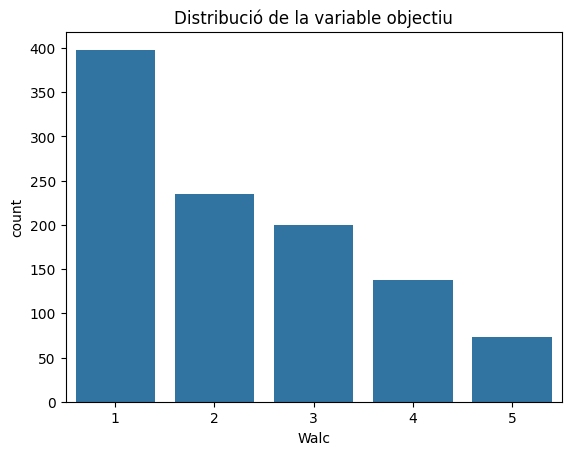

In [35]:
class_counts = dataset['Walc'].value_counts()
print("Comptatge de cada classe:")
print(class_counts.to_string())

sns.countplot(x='Walc', data=dataset)
plt.title('Distribució de la variable objectiu')
plt.show()

Vist la proporció dels 5 nivells de consum, observem clarament un desbalanç considerable i una forta tendència a haver-hi més alumnes que consumeixen poc alcohol. El nivell 1 indica baix consum, mentre que el nivell 5 indica consum alt.

En tenir molt poques mostres d'alumnes que consumeixen molt alcohol, prendrem la decisió de destinar un 80% de les dades al train i un 20% a la part de test, a més a més de que es farà una partició equilibrada.

In [36]:
train, test = train_test_split(dataset, train_size=0.8, stratify=dataset['Walc'], random_state=42)

dataset.head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
5,GP,M,16,U,LE3,T,4,3,services,other,...,5,4,2,1,2,5,10,15,15,15
6,GP,M,16,U,LE3,T,2,2,other,other,...,4,4,4,1,1,3,0,12,12,11
7,GP,F,17,U,GT3,A,4,4,other,teacher,...,4,1,4,1,1,1,6,6,5,6
8,GP,M,15,U,LE3,A,3,2,services,other,...,4,2,2,1,1,1,0,16,18,19
9,GP,M,15,U,GT3,T,3,4,other,other,...,5,5,1,1,1,5,0,14,15,15


Procedirem a mostrar les dimensions obtingudes tant del dataset amb el qual treballem com del train que analitzarem i del test.

In [37]:
print("El nombre de mostres que tenim a la base de dades és de",dataset.shape[0])
print("El nombre de atributs que tenim a la base de dades és de",dataset.shape[1])

print("El nombre de mostres que tenim al train és de",train.shape[0])
print("El nombre de atributs que tenim al train és de",train.shape[1])

print("El nombre de mostres que tenim al test és de",test.shape[0])
print("El nombre de atributs que tenim al test és de",test.shape[1])

El nombre de mostres que tenim a la base de dades és de 1044
El nombre de atributs que tenim a la base de dades és de 33
El nombre de mostres que tenim al train és de 835
El nombre de atributs que tenim al train és de 33
El nombre de mostres que tenim al test és de 209
El nombre de atributs que tenim al test és de 33


Tenim una mida decent per part del dataset complet i d'igual manera con s'ha mencionat el train i el test seràn proporcionals al dataset.

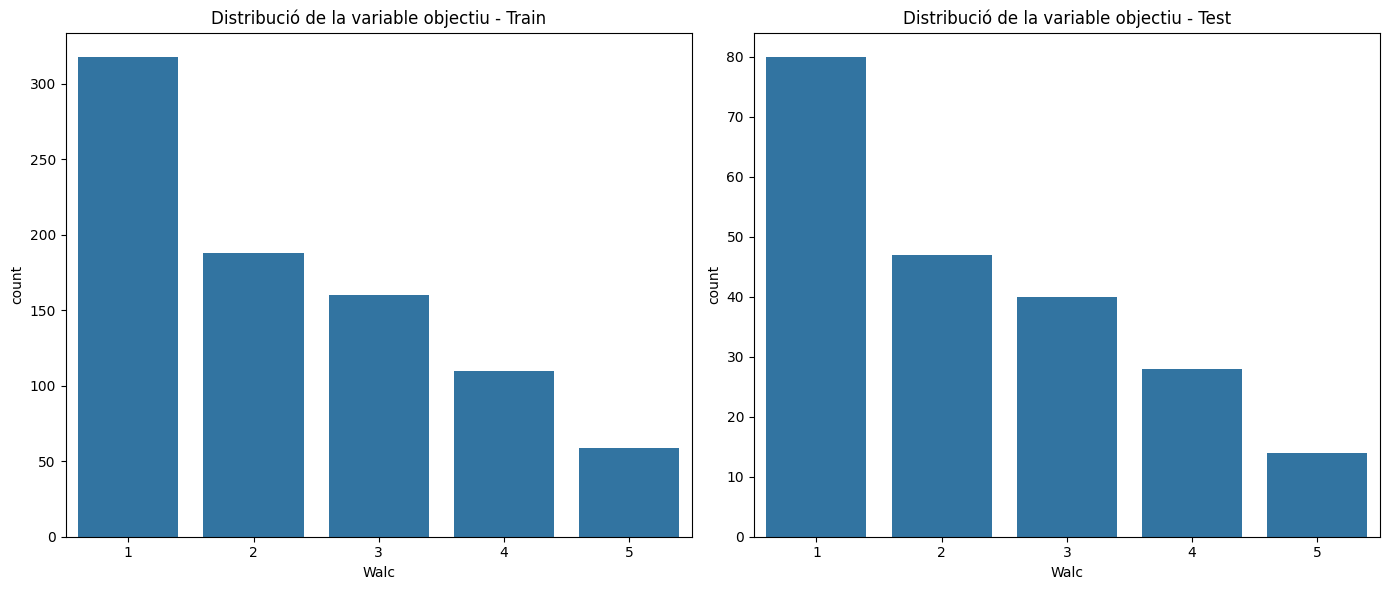

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 fila y 2 columnas

sns.countplot(x='Walc', data=train, ax=axes[0])
axes[0].set_title('Distribució de la variable objectiu - Train')

sns.countplot(x='Walc', data=test, ax=axes[1])
axes[1].set_title('Distribució de la variable objectiu - Test')

plt.tight_layout()
plt.show()

Es pot veure que disposem de 33 atributs diferents amb un total de 835 mostres, que utilitzarem per entrenar el nostre model i predir la variable objectiu. A continuació, analitzarem detalladament cada atribut per entendre millor el seu significat i la seva possible influència en la predicció del cosnum.

In [39]:
print("Informació de cada atribut:")
print(dataset.info())

Informació de cada atribut:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      1044 non-null   object
 1   sex         1044 non-null   object
 2   age         1044 non-null   int64 
 3   address     1044 non-null   object
 4   famsize     1044 non-null   object
 5   Pstatus     1044 non-null   object
 6   Medu        1044 non-null   int64 
 7   Fedu        1044 non-null   int64 
 8   Mjob        1044 non-null   object
 9   Fjob        1044 non-null   object
 10  reason      1044 non-null   object
 11  guardian    1044 non-null   object
 12  traveltime  1044 non-null   int64 
 13  studytime   1044 non-null   int64 
 14  failures    1044 non-null   int64 
 15  schoolsup   1044 non-null   object
 16  famsup      1044 non-null   object
 17  paid        1044 non-null   object
 18  activities  1044 non-null   object
 19  nursery     1044 non

- school: Fa referència a l'escola on estudia l'estudiant. És una variable binària que pot tenir dos valors possibles: 'GP' per Gabriel Pereira o 'MS' per Mousinho da Silveira, que són els noms de dues escoles diferents.

- sex: Indica el sexe de l'estudiant. És una variable binària on 'F' representa una dona i 'M' un home.

- age: És l'edat de l'estudiant, una variable numèrica que oscil·la entre els 15 i els 22 anys.

- address: Tipus d'adreça de la llar de l'estudiant. Aquesta variable és binària, amb 'U' per indicar que l'estudiant viu en una zona urbana i 'R' per indicar una zona rural.

- famsize: Fa referència a la mida de la família de l'estudiant. És també una variable binària on 'LE3' indica que la família té tres membres o menys i 'GT3' significa que la família té més de tres membres.

- Pstatus: Indica l'estat de convivència dels pares de l'estudiant. Pot ser 'T' per pares que viuen junts o 'A' per pares separats.

- Medu: Aquesta variable indica el nivell educatiu de la mare de l'estudiant. És numèrica i pot prendre els següents valors: 0 per cap educació, 1 per educació primària (fins al quart grau), 2 per educació de 5è a 9è grau, 3 per educació secundària, o 4 per educació superior.

- Fedu: Al igual que la variable anterior, Fedu indica el nivell educatiu del pare de l'estudiant amb els mateixos valors: 0 per cap educació, 1 per educació primària, 2 per educació de 5è a 9è grau, 3 per educació secundària, i 4 per educació superior.

- Mjob: La professió de la mare de l'estudiant. És una variable nominal que pot ser una de les següents: 'teacher' (mestra), relacionada amb la salut (salut), 'services' (com serveis civils com la policia o administració), 'at_home' (a casa), o 'other' (altres).

- Fjob: Fa referència a la professió del pare de l'estudiant, amb les mateixes opcions que la variable Mjob: 'teacher', 'health', 'services', 'at_home' i 'other'.

- reason: Motiu pel qual l'estudiant va triar aquesta escola en particular. Pot ser un dels següents: 'home' (perquè està a prop de casa), 'reputation' (per la bona reputació de l'escola), 'course' (preferència per l'assignatura), o 'other' (altres raons).

- guardian: Aquesta variable indica qui és el tutor legal de l'estudiant. Pot ser 'mother' (mare), 'father' (pare), o 'other' (un altre tutor).

- traveltime: Temps de desplaçament entre la casa i l'escola. És una variable numèrica on el valor pot ser 1 (menys de 15 minuts), 2 (de 15 a 30 minuts), 3 (de 30 minuts a 1 hora), o 4 (més d'1 hora).

- studytime: Temps d'estudi setmanal de l'estudiant. És també una variable numèrica amb els següents valors: 1 (menys de 2 hores), 2 (de 2 a 5 hores), 3 (de 5 a 10 hores), o 4 (més de 10 hores).

- failures: Nombre de suspensos en anteriors classes. És una variable numèrica on el valor pot ser 1, 2, o 3 si el nombre de suspensos és menor que 3, i 4 si l'estudiant ha suspès 3 o més classes.

- schoolsup: Indica si l'estudiant rep suport educatiu extra fora de les hores lectives. És binària, amb 'sí' o 'no'.

- famsup: Fa referència a si l'estudiant rep suport educatiu per part de la seva família. Aquesta també és una variable binària amb les opcions 'sí' o 'no'.

- paid: Aquesta variable indica si l'estudiant participa en classes pagades extra relacionades amb la matèria del curs, ja sigui Matemàtiques o Portuguès. També és binària, amb 'sí' o 'no'.

- activities: Indica si l'estudiant participa en activitats extraescolars. És una variable binària amb 'sí' o 'no'.

- nursery: Fa referència si l'estudiant va assistir a una escola bressol abans de començar l'escola primària. Pot ser 'sí' o 'no'.

- higher: Indica si l'estudiant té la intenció de continuar els seus estudis amb educació superior. També és binària, amb 'sí' o 'no'.

- internet: Aquesta variable indica si l'estudiant té accés a Internet a casa seva. És binària, amb 'sí' o 'no'.

- romantic: Indica si l'estudiant està en una relació romàntica. És binària, amb 'sí' o 'no'.

- famrel: Fa referència a la qualitat de les relacions familiars de l'estudiant. Aquesta és una variable numèrica, amb una escala de 1 (molt dolent) a 5 (excel·lent).

- freetime: Temps lliure que l'estudiant té després de l'escola. És una variable numèrica, amb una escala de 1 (molt baix) a 5 (molt alt).

- goout: Indica com d'apassionat és l'estudiant de sortir amb els seus amics. Aquesta variable numèrica té una escala de 1 (molt poc) a 5 (molt sovint).

- Dalc: Indica el consum d'alcohol de l'estudiant en dies laborables. És una variable numèrica, amb valors entre 1 (molt baix) i 5 (molt alt).

- Walc: Aquesta variable fa referència al consum d'alcohol durant els caps de setmana. Igual que Dalc, és una variable numèrica amb valors entre 1 (molt baix) i 5 (molt alt). (TARGET)

- health: Està relacionada amb l'estat de salut actual de l'estudiant. És una variable numèrica que va de 1 (molt dolent) a 5 (molt bo).

- absences: Indica el nombre d'absències que l'estudiant ha tingut a l'escola. Aquesta és una variable numèrica que pot oscil·lar entre 0 i 93.


- G1: Qualificació obtinguda per l'estudiant en el primer període del curs. És una variable numèrica que va de 0 a 20.

- G2: Qualificació obtinguda per l'estudiant en el segon període del curs. Aquesta també és una variable numèrica, de 0 a 20.

- G3: És la qualificació final obtinguda en l'assignatura, que pot ser un valor entre 0 i 20.